# Building Damage from Floods

## Economic Flood Risk Methodology

Flood risk in the form of economic damage at a building level is computed from flood depth maps and building data.  The damages are computed for each supplied flood event return period and then integrated over all of the event return periods to determine expected annual damage (EAD). Damage to each building varies based on the depth water, reconstruction costs, value of its contents, and its footprint area.

- River flood extent and water depth are from the [Copernicus Land Monitoring Service](https://data.jrc.ec.europa.eu/dataset/1d128b6c-a4ee-4858-9e34-6210707f3c81) for different event return periods at a 100m grid spacing.
- Building data including type and footprint are obtained from [OpenStreetMap](https://www.openstreetmap.org/copyright).
- Building damage fraction, reconstruction costs, and the value of its contents are determined using the [JRC methodology](https://publications.jrc.ec.europa.eu/repository/handle/JRC105688).

The code can be customized to use any flood depth hazard, building data, and depth-damage relationships.

### Import Modules

These modules are needed to process the flood depth raster data and building shapefiles as well as plot the results.
- [os](https://docs.python.org/3/library/os.html): For interacting with the operating system, allowing the creation of directories and file manipulation.
- [sys](https://docs.python.org/3/library/sys.html): Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- [numpy](https://numpy.org/): A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
- [pandas](https://pandas.pydata.org/): A data manipulation and analysis library, essential for working with structured data in tabular form.
- [geopandas](https://geopandas.org): Extends the datatypes used by pandas to allow spatial operations on geometric types.
- [rasterio](https://rasterio.readthedocs.io/en/stable/): For reading and writing geospatial raster data, providing functionalities to explore and manipulate raster datasets.
- [rasterstats](https://pythonhosted.org/rasterstats): For summarizing geospatial raster datasets based on vector geometries.
- [shapely](https://pypi.org/project/shapely/): For manipulation and analysis of planar geometric objects.
- [osgeo](https://www.osgeo.org/): For translating raster and vector geospatial data formats.
- [osmnx](https://osmnx.readthedocs.io/) To easily download, model, analyze, and visualize street networks and other geospatial features from OpenStreetMap.
- [pyproj](https://pyproj4.github.io/pyproj/dev/index.html): Interface for PROJ (cartographic projections and coordinate transformations library).
- [matplotlib](https://matplotlib.org/): Used for creating static, animated, and interactive visualizations.
- [contextily](https://contextily.readthedocs.io/en/latest/): For adding basemaps to plots, enhancing geospatial visualizations.
- [urllib.request](https://docs.python.org/3/library/urllib.request.html): Defines functions and classes which help in opening URLs (mostly HTTP) in a complex world — basic and digest authentication, redirections, cookies and more.
- [zipfile](https://docs.python.org/3/library/zipfile.html): Provides tools to create, read, write, append, and list a ZIP file.
- [sockect](https://docs.python.org/3/library/socket.html): pPovides access to the BSD socket interface.

In [57]:
"""%pip install rasterio #Requirments, should be installed
%pip install rasterstats
%pip install osmnx
%pip install contextily"""

'%pip install rasterio #Requirments, should be installed\n%pip install rasterstats\n%pip install osmnx\n%pip install contextily'

In [58]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
from rasterio.warp import reproject, calculate_default_transform
from rasterio.mask import mask
from rasterio.crs import CRS
import rasterstats
from osgeo import gdal, osr, ogr
from shapely.geometry import box, Polygon, shape
import osmnx as ox
from pyproj import Transformer
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import contextily as ctx
import urllib.request
import zipfile
from zipfile import ZipFile
import socket


## Definitions

- Bounds of area of interest.  Positive values denote north and east, and negative values denote south and west.
- Code flags
- Return periods
- Directory locations
- Colorbars for maps

In [59]:
##LOCATION (in ESPG:4326):----------------------------
# Florence, Italy
Latitude1, Latitude2 = 43.76, 43.79
Longitude1, Longitude2 = 11.24, 11.30

# Žilina, Slovakia
Latitude1, Latitude2 = 49.2, 49.25
Longitude1, Longitude2 = 18.69, 18.78

# Annecy, France
#Latitude1, Latitude2 = 45.8814467806907, 45.9275551174562
#Longitude1, Longitude2 = 6.186423140359138, 6.079306441308494


Latitude1, Latitude2 = min(Latitude1, Latitude2), max(Latitude1, Latitude2)
Longitude1, Longitude2 = min(Longitude1, Longitude2), max(Longitude1, Longitude2)

# Return Periods of Interest
ReturnPeriods = [10, 20, 50, 100, 200, 500]  # Return period levels, if using original source pick from [10, 20, 50, 100, 200, 500]

# Population estimate/projection year
PopYear = 2025 #Can choose any year with a 5 year interval between 1975 and 2030 (estimates until 2020, projections after 2020)

if not (isinstance(PopYear, int) and 1975 <= PopYear <= 2030 and PopYear % 5 == 0):
    raise ValueError("The variable must be an integer, between 1975 and 2030, and a multiple of 5.")

# Water Depths for Exposed and Displaced Population
minDepthExposed = 0.1 #if depth is greater than this, the population is exposed
minDepthDisplaced = 1.0 #if depth is greater than this, the population is displaced


##OPTIONAL:------------------------------------------
# Return period for the optional figures. If using original source pick from [10, 20, 50, 100, 200, 500]
ImageReturnPeriod = [100] #Leave blank for no additional figures.

# Damage curves (True prints)
flagDamageCurve = True

# Building Images (True prints)
    #Building maps with classification 
flagBuilding = True
    #Building maps with flood level
flagBuildingH2o = True
    #Building maps with damage received
flagBuildingDmg = True
    #Annual damage by return period graph
flagBuildingDmgGraph = True

# Population Images (True prints)
    #Population exposed map
flagPopulationExp = True
    #Annual population exposed graph
flagPopulationExpGraph = True
    #Population displaced map
flagPopulationDis = True
    #Annual population displaced graph
flagPopulationDisGraph = True


##DATA MANAGEMENT:----------------------------------
RP, tile_id_max = True,0 #Temporary initiation, will automatically change in workflow

# Directory of main folder (working directory)
dirWork = '.'
os.chdir(dirWork)

# Input Hazard Path
dirDepths = os.path.join(dirWork, 'data')
if not os.path.exists(dirDepths):
    os.makedirs(dirDepths)

# OSM Output Path
dirOSM = os.path.join(dirWork, 'OSM')
if not os.path.exists(dirOSM):
    os.makedirs(dirOSM)

# Results directory
dirResults = os.path.join(dirWork, 'DamageBuildings')
if not os.path.exists(dirResults):
    os.makedirs(dirResults)
dirResultsPop = os.path.join(dirWork, 'ExposePopulation')
if not os.path.exists(dirResultsPop):
    os.makedirs(dirResultsPop)


##FIGURE COLOUR SCHEMES:-------------------------------

# Water Depth Colorbar for Maps
cmap_h2o = LinearSegmentedColormap.from_list('gist_stern_inv',
                                             ['cyan', 'blue', 'red'], N=256)
# Building Class Colorbar for Maps
cmap_cls = LinearSegmentedColormap.from_list('gist_stern_inv',
                                             ['orange','purple', 'blue', 'red'], N=256)
# Population Colorbar for Maps
cmap_pop = LinearSegmentedColormap.from_list('gist_stern_inv',
                                             ['orange', 'red','fuchsia'], N=256)
# Damage Colorbar for Maps
cmap_dmg = LinearSegmentedColormap.from_list('gist_stern_inv',
                                             ['blue', 'red','fuchsia'], N=256)



## Download Data

- Download flood depth rasters to the data folder if the file doesn't exist.
- River flood extent and water depth are from the [Copernicus Land Monitoring Service](https://data.jrc.ec.europa.eu/dataset/1d128b6c-a4ee-4858-9e34-6210707f3c81) for different event return periods at a 100m grid spacing.

In [60]:
#This workflow is using European data. If personal data wants to be used
#Note: There is a known issue with Mollweide projections. Standard projection used is 'EPSG:4326'

timeout = 90    # Download time out in seconds
max_retries = 5  # Maximum number of download attempts
socket.setdefaulttimeout(timeout)

##Flood data download
urlData='https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-EFAS/flood_hazard/'

for RP in ReturnPeriods:
    print(f'Return Period={str(RP)}')
    rastDepths = os.path.join(dirDepths, f'Europe_RP{RP}_filled_depth.tif')
    if os.path.exists(rastDepths):
        print(f'Flood depth raster already exists (skipping download): {rastDepths}')
    else:
        rastTif = f'Europe_RP{RP}_filled_depth.tif'
        pathRastTif = os.path.join(dirDepths, rastTif)
        urlRastTif = os.path.join(urlData, rastTif)
        print(urlRastTif)
        for attempt in range(1, max_retries + 1):
            print(f'    Attempt: {attempt}')
            try:
                urllib.request.urlretrieve(urlRastTif, pathRastTif)
                break  # Break loop if download is successful
            except Exception as e:
                print('      Timeout.  Retry data download')
                if attempt == max_retries:
                    print('    Maximum number of timeouts reached.  Data download failed')
                    print(f'      Consider increasing timeout value {timeout} seconds')
                    print(f'      Consider increasing maximum number of download attempts {max_retries}')
                    raise Exception(f'Timeout time {timeout} seconds exceeded {max_retries}')
        print('  Unzipping downloaded file')


##Population data download 
urlDataPopScheme='https://ghsl.jrc.ec.europa.eu/download/'
shpPopScheme = os.path.join(dirDepths, f'WGS84_tile_schema.shp')
if os.path.exists(shpPopScheme):
    print(f'Population scheme shapefile already exists (skipping download)')
else:
    rastZip = f'GHSL_data_4326_shapefile.zip'
    pathRastZip = os.path.join(dirDepths, rastZip)
    urlRastZip = os.path.join(urlDataPopScheme, rastZip)
    print(urlRastZip)
    for attempt in range(1, max_retries + 1):
        print(f'    Attempt: {attempt}')
        try:
            urllib.request.urlretrieve(urlRastZip, pathRastZip)
            break  # Break loop if download is successful
        except Exception as e:
            print('      Timeout.  Retry data download')
            if attempt == max_retries:
                print('    Maximum number of timeouts reached.  Data download failed')
                print(f'      Consider increasing timeout value {timeout} seconds')
                print(f'      Consider increasing maximum number of download attempts {max_retries}')
                raise Exception(f'Timeout time {timeout} seconds exceeded {max_retries}')
    print('  Unzipping downloaded file')
    with ZipFile(pathRastZip, 'r') as zip_ref:
        zip_ref.extractall(dirDepths)

# Load the shapefile
gdf = gpd.read_file(shpPopScheme)


# Iterate through each polygon and check if the point is inside
tile_id_min, tile_id_max = None, None 
for index, row in gdf.iterrows():
    left, top, right, bottom = row['left'], row['top'], row['right'], row['bottom']
    # Check if the point is within the bounding box of the polygon
    if left <= Longitude1 <= right and bottom <= Latitude1 <= top:
        tile_id_min = row['tile_id']
    if left <= Longitude2 <= right and bottom <= Latitude2 <= top:
        tile_id_max = row['tile_id']
    if tile_id_min is not None and tile_id_max is not None:
        break

if tile_id_min == tile_id_max:
    print(f'Population tile id: {tile_id_max}')
    urlDataPop=f'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss/V1-0/tiles/'
    print(f'Population C20')
    rastPopulation= os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_max}.tif')
    if os.path.exists(rastPopulation):
        print(f'Population raster already exists (skipping download)')
    else:
        rastZip = f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_max}.zip'
        pathRastZip = os.path.join(dirDepths, rastZip)
        urlRastZip = os.path.join(urlDataPop, rastZip)
        print(urlRastZip)
        for attempt in range(1, max_retries + 1):
            print(f'    Attempt: {attempt}')
            try:
                urllib.request.urlretrieve(urlRastZip, pathRastZip)
                break  # Break loop if download is successful
            except Exception as e:
                print('      Timeout.  Retry data download')
                if attempt == max_retries:
                    print('    Maximum number of timeouts reached.  Data download failed')
                    print(f'      Consider increasing timeout value {timeout} seconds')
                    print(f'      Consider increasing maximum number of download attempts {max_retries}')
                    raise Exception(f'Timeout time {timeout} seconds exceeded {max_retries}')
        print('  Unzipping downloaded file')
        with ZipFile(pathRastZip, 'r') as zip_ref:
            zip_ref.extract(f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_max}.tif',dirDepths)
else:
    raise ValueError(f"Location crosses population rasters {tile_id_min} and {tile_id_max}. Modify location or use personal data.)")

Return Period=10
Flood depth raster already exists (skipping download): .\data\Europe_RP10_filled_depth.tif
Return Period=20
Flood depth raster already exists (skipping download): .\data\Europe_RP20_filled_depth.tif
Return Period=50
Flood depth raster already exists (skipping download): .\data\Europe_RP50_filled_depth.tif
Return Period=100
Flood depth raster already exists (skipping download): .\data\Europe_RP100_filled_depth.tif
Return Period=200
Flood depth raster already exists (skipping download): .\data\Europe_RP200_filled_depth.tif
Return Period=500
Flood depth raster already exists (skipping download): .\data\Europe_RP500_filled_depth.tif
Population scheme shapefile already exists (skipping download)
Population tile id: R4_C20
Population C20
Population raster already exists (skipping download)


## Define Depth-Damage Functions

Maximum Damage Values
- Huizinga, J., Moel, H. de, Szewczyk, W. (2017). Global flood depth-damage functions. Methodology and the database with guidelines. EUR 28552 EN. doi: 10.2760/16510)
- First array value is 2010 building reconstruction costs per square meter
- Second value is 2010 building content replacement value per square meter
- CPI2010 = 2010 [World Bank Consumer Price Index](https://data.worldbank.org/indicator/FP.CPI.TOTL) for country of interest
- CPI2022 = 2022 Consumer Price Index for country of interest (latest value)

Damage Classes
- Options are Residential, Commercial, Industrial, Agriculture, Cultural, and Transportation.
- In the default code, Agriculture, Cultural, and Transportation as well as unclassified buildings are set to commercial

Damage Function
- Based on polynomial functions fit to the JRC depth-damage curves, with the order depending on fit (coefs).
- In the default code, a combined damage function is applied based on Residential, Commercial, and Industrial JRC depth-damage values
- Huizinga, J., Moel, H. de, Szewczyk, W. (2017). Global flood depth-damage functions. Methodology and the database with guidelines. EUR 28552 EN. doi: 10.2760/16510

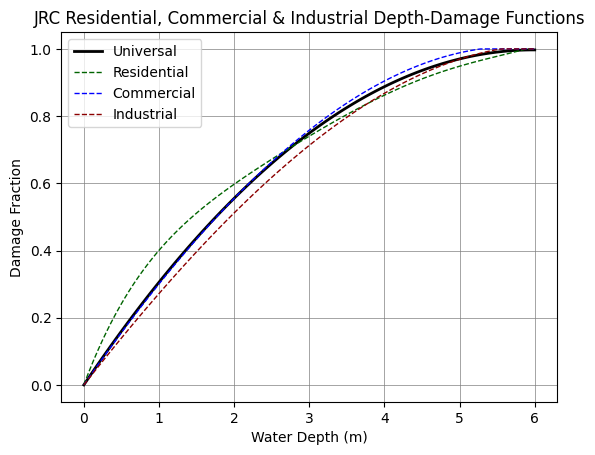

In [61]:
# Define arrays for damage values based on 2010 estimates
CPI2010 = 100                                  # 2010 EU Value
CPI2022 = 121.8                                # 2022 EU Value
CPI_Frac = CPI2022 / CPI2010
MaxDmgRES = np.array([480, 240]) * CPI_Frac    # EU Value
MaxDmgCOM = np.array([502, 502]) * CPI_Frac    # EU Value
MaxDmgIND = np.array([328, 492]) * CPI_Frac    # EU Value
MaxDmgAGR = np.array([0.23, 0.46]) * CPI_Frac  # Italy 2021 (AGR), 0.23 EUR/m2
MaxDmgCUL = MaxDmgCOM                          # EU Value
MaxDmgTRS = MaxDmgIND                          # Italy 2021 (TRS)
MaxDmgUNI = (MaxDmgRES+MaxDmgCOM+MaxDmgIND)/3
# Combine damage arrays into a single array
MaxDmg = np.column_stack((MaxDmgRES, MaxDmgCOM, MaxDmgIND, MaxDmgUNI))

# Compute damages based on Mean, Maximum, and/or Minimum depths
#   Options are ['Mean', 'Maximum', 'Minimum']
Depths = ['Mean']

# Damage classes
DamageClasses = ['Residential', 'Commercial', 'Industrial','Universal']

def DamageFunction(wd1, coefs, wd_range=(0, 6)):
    wd = np.clip(wd1, *wd_range)
    y = coefs[0] * wd**5 + coefs[1] * wd**4 + coefs[2] * wd**3 \
        + coefs[3] * wd**2 + coefs[4] * wd + coefs[5]
    y = np.clip(y, 0, 1)
    return y

# Polynomial coefficients for each function
#   - Up to 5th order
#   - 1st value is highest order (5th) and last is intercept
coefs_UNI = [0.0,  0.0, 0.0, -0.02787, 0.3334, 0.0]
coefs_RES = [0.0005869, -0.01077, 0.07497, -0.2602, 0.5959, 0.0]
coefs_COM = [0.0, 0.0, -0.0009149, -0.02021, 0.3216, 0.0]
coefs_IND = [0.0, 0.0, -0.001202, -0.01225, 0.2852, 0.0]
coefs_TRS = [0.0, -0.00938, 0.07734, -0.2906, 0.7625, 0.0]
coefs_AGR = [0.0, -0.004601, 0.06114, -0.3061, 0.7773, 0.0]

# Plot Depth Damage Functions
# Water depth values from 0 to 6m
wd_values = np.linspace(0, 6, 100)
dmgRES = DamageFunction(wd_values, coefs_RES)
dmgCOM = DamageFunction(wd_values, coefs_COM)
dmgIND = DamageFunction(wd_values, coefs_IND)
dmgUNI = DamageFunction(wd_values, coefs_UNI)
if flagDamageCurve is True:
    plt.plot(wd_values, dmgUNI, color='black', linewidth=2, label='Universal')
    plt.plot(wd_values, dmgRES, color='darkgreen', linestyle='--', linewidth=1,
            label='Residential')
    plt.plot(wd_values, dmgCOM, color='blue', linestyle='--', linewidth=1,
            label='Commercial')
    plt.plot(wd_values, dmgIND, color='darkred', linestyle='--', linewidth=1,
            label='Industrial')
    plt.grid(color='grey', linestyle='-', linewidth=0.5)
    plt.xlabel('Water Depth (m)')
    plt.ylabel('Damage Fraction')
    plt.title('JRC Residential, Commercial & Industrial Depth-Damage Functions')
    plt.legend()
    plt.show()

### Bounding Box Computations
- Converts latitude and longitude values to the evuivalent projection used by the water depth raster Projection, bounds of zoom raster & write bounding box to shapefile
- Defines bounding box for OpenStreetMap data.

Here the selected bounding box of the data can be checked by looking at the generated map.  If the region of interest is not as desired, the latitude and longitude values can be changed above.

Raster Projection EPSG:4326
Converted Coordinate Bounds
  Longitudes: 18.69E --> 18.69 meters & 18.78E --> 18.78 meters
  Latitudes: 49.2N --> 49.2 meters & 49.25N --> 49.25 meters
Bounding Box Shapefile written to: .\OSM\bbox.shp
  49.2N to 49.25N
  18.69E to 18.78E


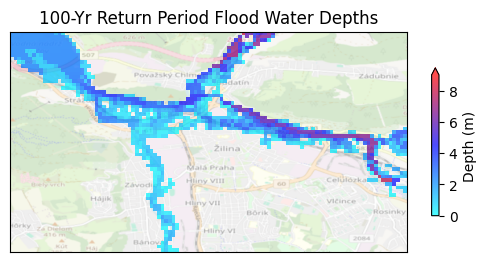

Adjust latitude and longitude bounds as needed
  49.2N to 49.25N
  18.69E to 18.78E
EPSG:4326
Raster Projection EPSG:4326
Converted Coordinate Bounds
  Longitudes: 18.69E --> 18.69 meters & 18.78E --> 18.78 meters
  Latitudes: 49.2N --> 49.2 meters & 49.25N --> 49.25 meters


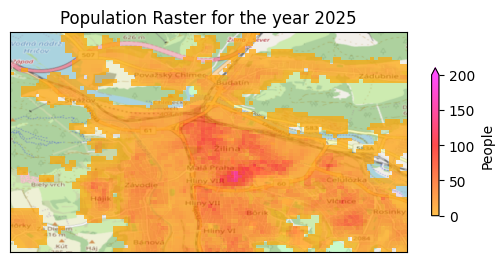

Adjust latitude and longitude bounds as needed
  49.2N to 49.25N
  18.69E to 18.78E


In [62]:
#Set shape box location
shpBBox = os.path.join(dirOSM, 'bbox.shp')

# Determine Raster EPSG Code (only works with osgeo)
ds = gdal.Open(rastDepths)
srs = osr.SpatialReference()
srs.ImportFromWkt(ds.GetProjection())
epsgRast = f'EPSG:{srs.GetAuthorityCode(None)}'
ds = None

print(f'Raster Projection {epsgRast}')

# Create a transformer for coordinate conversion
transformer = Transformer.from_crs('EPSG:4326', epsgRast, always_xy=True)

# Convert bounding box coordinates to raster CRS
xMin, yMin = transformer.transform(Longitude1, Latitude1)
xMax, yMax = transformer.transform(Longitude2, Latitude2)

# Ensure xMin < xMax and yMin < yMax
xMin, xMax = min(xMin, xMax), max(xMin, xMax)
yMin, yMax = min(yMin, yMax), max(yMin, yMax)

print('Converted Coordinate Bounds')
print(f'  Longitudes: {Longitude1}E --> {xMin} meters & {Longitude2}E --> {xMax} meters')
print(f'  Latitudes: {Latitude1}N --> {yMin} meters & {Latitude2}N --> {yMax} meters')

# Define the bounding box coordinates based on the zoomed region
bboxRast = box(xMin, yMin, xMax, yMax)
bounding_box = gpd.GeoDataFrame(geometry=[bboxRast], crs=epsgRast)

# Write the GeoDataFrame to a shapefile
bounding_box.to_file(shpBBox)
print('Bounding Box Shapefile written to: '+shpBBox)

# Read GeoDataFrame from the bounding box shapefile
gdfBBox = gpd.read_file(shpBBox)
crsRast = gdfBBox.crs
bboxRast = gdfBBox.total_bounds

# Adjust bounding box coordinates for OSM data
bboxOSM = bboxRast
bboxOSM[1] = Latitude1
bboxOSM[3] = Latitude2
bboxOSM[0] = Longitude1
bboxOSM[2] = Longitude2

# Create a GeoSeries representing the bounding box polygon
bboxOSM_poly = gpd.GeoSeries(
    [Polygon([(bboxOSM[0], bboxOSM[1]), (bboxOSM[2], bboxOSM[1]),
              (bboxOSM[2], bboxOSM[3]), (bboxOSM[0], bboxOSM[3])])],
    crs=crsRast
)
bboxOSM_poly = bboxOSM_poly.to_crs(crsRast)

print(f'  {str(Latitude1)}N to {str(Latitude2)}N')
print(f'  {str(Longitude1)}E to {str(Longitude2)}E')
for RP in ImageReturnPeriod:
    rastDepths = os.path.join(dirDepths, f'Europe_RP{RP}_filled_depth.tif')
    # Read the raster using rasterio
    with rasterio.open(rastDepths) as src:
        window = from_bounds(xMin, yMin, xMax, yMax, src.transform)
        rDepths = src.read(1, window=window)
        rDepths = np.ma.masked_where((rDepths < -999) | (rDepths > 1000), rDepths)
        # Compute the maximum value from the masked data
        max_depth  = rDepths.max()
        
        # Find the closest multiple of 100 above the max_population value
        maxDepthLegend = ((max_depth // 1) + 1)
        missing_data_value = src.nodata
    # Check select bounding latitude-longitude box
    fig, ax = plt.subplots()
    im = ax.imshow(rDepths, vmin=0, vmax=maxDepthLegend, cmap=cmap_h2o, extent=(xMin, xMax, yMin, yMax),
                zorder=2, alpha=0.7)
    cbar = fig.colorbar(im, ax=ax, extend='max', orientation='vertical', label='Depth (m)', shrink=0.4)
    ctx.add_basemap(ax, crs=epsgRast, source=ctx.providers.OpenStreetMap.Mapnik,
                    attribution='', alpha=0.5)
    ax.set_xticks([]), ax.set_yticks([])
    plt.title(f'{RP}-Yr Return Period Flood Water Depths')
    plt.show()

print('Adjust latitude and longitude bounds as needed')
print(f'  {str(Latitude1)}N to {str(Latitude2)}N')
print(f'  {str(Longitude1)}E to {str(Longitude2)}E')
print(epsgRast)

##--------------------------------------------------------
## Population map

# File paths
shpBBoxPop = os.path.join(dirOSM, 'bbox_pop.shp')

# Open the raster file
ds = gdal.Open(rastPopulation)
if ds is None:
    raise RuntimeError(f"Failed to open the raster file: {rastPopulation}")

# Get the projection from the raster file
proj_wkt = ds.GetProjection()
srs = osr.SpatialReference()
srs.ImportFromWkt(proj_wkt)

# Try to get the EPSG code
epsg_code = srs.GetAuthorityCode(None)

# Check if the EPSG code was successfully retrieved
if epsg_code is None:
    # If not, you might need to handle specific cases manually
    # Check if the projection matches known projections
    proj4_str = srs.ExportToProj4()
    if '+proj=moll' in proj4_str and '+datum=WGS84' in proj4_str:
        epsg_code = 'EPSG:54009'  # ESRI:54009 World Mollweide projection
    else:
        raise RuntimeError("Unable to determine EPSG code for the given projection.")
else:
    epsg_code = f"EPSG:{epsg_code}"

epsgRastPop = epsg_code
# Close the dataset
ds = None
print(f'Raster Projection {epsgRastPop}')

# Create a transformer for coordinate conversion
if epsg_code == 'EPSG:54009':
    PopProj = '+proj=moll +datum=WGS84 +units=m' #MOLLWEIDE HAS TO BE MANUALLY INSERTED
else:
    PopProj = epsg_code

transformer = Transformer.from_crs('EPSG:4326', PopProj, always_xy=True)

# Convert bounding box coordinates to raster CRS
xMinPop, yMinPop = transformer.transform(Longitude1, Latitude1)
xMaxPop, yMaxPop = transformer.transform(Longitude2, Latitude2)

# Ensure xMin < xMax and yMin < yMax
xMinPop, xMaxPop = min(xMinPop, xMaxPop), max(xMinPop, xMaxPop)
yMinPop, yMaxPop = min(yMinPop, yMaxPop), max(yMinPop, yMaxPop)

print('Converted Coordinate Bounds')
print(f'  Longitudes: {Longitude1}E --> {xMinPop} meters & {Longitude2}E --> {xMaxPop} meters')
print(f'  Latitudes: {Latitude1}N --> {yMinPop} meters & {Latitude2}N --> {yMaxPop} meters')

# Read the raster using rasterio
with rasterio.open(rastPopulation) as src:
    window = from_bounds(xMinPop, yMinPop, xMaxPop, yMaxPop, src.transform)
    rPopulation = src.read(1, window=window)
    rPopulation = np.ma.masked_where((rPopulation < 0.1), rPopulation)
    max_population = rPopulation.max()
    maxPopLegend = ((max_population // 100) + 1) * 100
    missing_data_value = src.nodata
    

fig, ax = plt.subplots()
im = ax.imshow(rPopulation, vmin=0, vmax=maxPopLegend, cmap=cmap_pop, extent=(xMinPop, xMaxPop, yMinPop, yMaxPop),
               zorder=2, alpha=0.7)
cbar = fig.colorbar(im, ax=ax, extend='max', orientation='vertical', label='People', shrink=0.4)
ctx.add_basemap(ax, crs=PopProj, source=ctx.providers.OpenStreetMap.Mapnik,
                attribution='', alpha=1)
ax.set_xticks([]), ax.set_yticks([])
plt.title(f'Population Raster for the year {PopYear}')
plt.show()

print('Adjust latitude and longitude bounds as needed')
print(f'  {str(Latitude1)}N to {str(Latitude2)}N')
print(f'  {str(Longitude1)}E to {str(Longitude2)}E')

### OpenStreetMap Building Data

Here the OSM data are loaded based on the bounding box defined above.  The extracted data represent the building use (unclassified) are written to a shapefile.

C:\Users\Serrao\AppData\Local\Temp\ipykernel_2724\3597872067.py:7: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdfOSM = ox.geometries_from_polygon(bboxOSM_poly.iloc[0], tags)
C:\Users\Serrao\AppData\Local\Temp\ipykernel_2724\3597872067.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  gdfOSM = gdfOSM.applymap(lambda x: str(x) if isinstance(x, list) else x)
C:\Users\Serrao\AppData\Local\Temp\ipykernel_2724\3597872067.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfOSM.to_file(shpOSM, driver='ESRI Shapefile', encoding='utf-8')#ADDED ENCODING UTF-8 TO BE ABLE TO PROCESS SPECIAL CHARACTERS

OSM data read in and saved to shapefile
  .\OSM\OSM_Building_Unclassified.shp


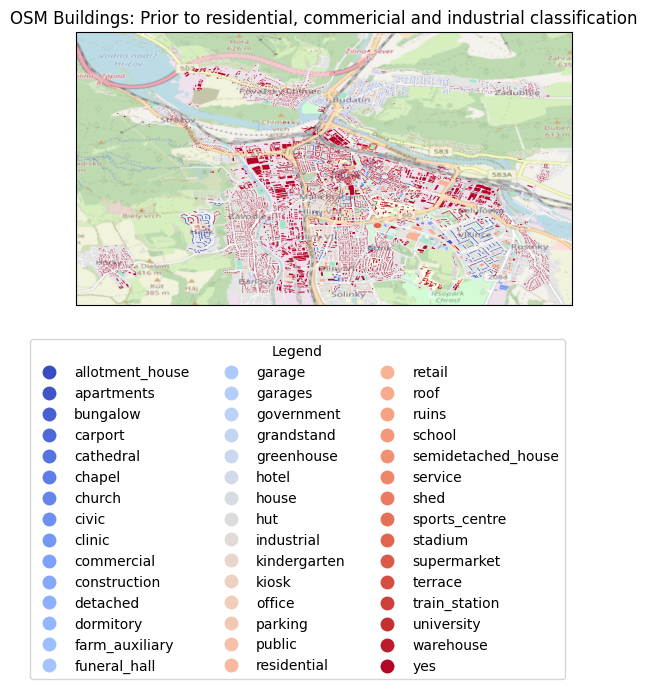

In [63]:
# Output shapefile for unclassified buildings
shpOSM = os.path.join(dirOSM, 'OSM_Building_Unclassified.shp')

# Define tags for OSM data
tags = {'building': True}
# Retrieve OSM geometries within the bounding box
gdfOSM = ox.geometries_from_polygon(bboxOSM_poly.iloc[0], tags)
# Filter out non-Polygon geometries
gdfOSM = gdfOSM[gdfOSM.geom_type == 'Polygon']
# Confirm that all of the GDF elements are compatible with shp format
gdfOSM = gdfOSM.applymap(lambda x: str(x) if isinstance(x, list) else x)
# Clip the OSM data to the bounding box
gdfOSM = gpd.clip(gdfOSM, bboxOSM)
# Save the polygon-only gdp to shapefile
gdfOSM.to_file(shpOSM, driver='ESRI Shapefile', encoding='utf-8')#ADDED ENCODING UTF-8 TO BE ABLE TO PROCESS SPECIAL CHARACTERS FOUND IN OSM
print('OSM data read in and saved to shapefile')

print('  '+shpOSM)

if flagBuilding is True:
  # Plot data
  ax = gdfOSM.plot(column='building', legend=True, cmap='coolwarm', legend_kwds={'ncol': 3})
  ctx.add_basemap(ax, crs=gdfOSM.crs, source=ctx.providers.OpenStreetMap.Mapnik,
                  attribution='', alpha=0.8)
  ax.set_xticks([]), ax.set_yticks([])
  plt.title('OSM Buildings: Prior to residential, commericial and industrial classification')
    # Get the legend
  legend = ax.get_legend()
  # Set the number of columns in the legend
  legend._ncol = 3  # Adjust the number of columns as per your preference
  # Adjust the layout of the legend
  legend.set_bbox_to_anchor((1, -.1))  # Adjust the anchor point as per your preference
  legend.set_title('Legend')  # Set the title of the legend
  plt.show()

### Reproject OSM data to raster projection

In order to perform the damage analysis, the OSM and raster data need to be on the same Coordinate Reference System (CRS). The OSM are on an EPSG:4326 CRS and the raster data could be another.  In the cell, the OSM data are converted to match the raster CRS.

In [64]:
# Determine CRSs from shapefile and Raster
crsOSM = gdfOSM.crs

if crsOSM not in (epsgRast, epsgRast.lower()):

    print(f'Reprojecting from OSM {crsOSM} to raster EPSG:{epsgRast}')

    # Read the GeoDataFrame if reprojection is needed
    gdfOSM = gpd.read_file(shpOSM)
    # Reproject the GeoDataFrame to match the raster CRS
    gdfOSM = gdfOSM.to_crs(epsg=epsgRast)
    # Save the reprojected data back to the shapefile
    gdfOSM.to_file(shpOSM)
    print('  Overwriting reprojected data:', shpOSM)

else:

    print('No reprojection performed. Both projections are the same:', crsOSM)

print('Done')

No reprojection performed. Both projections are the same: epsg:4326
Done


### Building classifications
In this cell, the building types are classified to Residential, Commercial, Industrial, etc.
- This procedure needs to be performed manually by looking at the outputed list.
- If None is listed for a building class (bldgClass column), the building type (building column) should be assigned to one of the lists (e.g., classResidential, classCommercial, classIndustrial).
- Buildings with type "yes" will be classified as Commercial by default in a later step.

In [65]:
# CSV file with classifications (classResidential, classCommercial, etc)
csvOSMclasses = os.path.join(dirOSM, 'OSM_Building_Reclassified.csv')

 # Keep only the building and geometry columns
gdfBuildings = gdfOSM[['building','geometry']].copy()

# Building classifications
#   - Change and add as needed
classResidential = ['hut', 'apartments', 'detached', 'residential', 'house', 'barn', 'garage',
                    'carport', 'semidetached_house', 'shed', 'bungalow', 'roof', 'terrace',
                    'allotment_house']
classCommercial = ['commercial', 'office', 'retail', 'kiosk', 'supermarket', 'warehouse',
                   'garages', 'hotel', 'stadium', 'grandstand', 'sports_centre',  'pavilion',
                   'government', 'school', 'kindergarten', 'university', 'dormitory', 'public',
                   'service', 'hospital', 'clinic', 'civic', 'terminal', 'fire_station',
                   'train_station', 'boathouse', 'toilets', 'tech_cab', 'tower', 'portal',
                   'columbarium', 'cloister', 'greenhouse', 'guardhouse', 'construction',
                   'funeral_hall']
classIndustrial = ['industrial', 'manufacture']
classCultural = ['church', 'cathedral', 'baptistery', 'obelisk', 'basilica', 'monastery', 'ruins',
                 'column', 'chapel', 'synagogue', 'shrine', 'religious', 'convent', 'fort']
classAgricultural = ['farm_auxiliary']
classTransportation = ['bridge', 'parking']
classUniversal = ['universal']

# Critical infrastructure -------
criticalInfrastructureList = ['hospital', 'public','train_station','transformer_tower','water_tower','bridge',
                          'fire_station','transportation','service']

# For now, set transportation and cultural to universal (can add/change if desired)
classUniversal = classUniversal + classCultural + classAgricultural + classTransportation
classCultural = []
classAgricultural = []
classTransportation = []

# Convert building classes to dataframe
bldgClasses = pd.DataFrame({'building': gdfBuildings['building'].unique()})

# Classify each structure to Residential, Commercial, Industrial, etc.
#   - Structures not listed in above class lists are classified as none
bldgClasses['bldgClass'] = None
bldgClasses.loc[bldgClasses['building'].isin(classResidential), 'bldgClass'] = 'Residential'
bldgClasses.loc[bldgClasses['building'].isin(classCommercial), 'bldgClass'] = 'Commercial'
bldgClasses.loc[bldgClasses['building'].isin(classIndustrial), 'bldgClass'] = 'Industrial'
bldgClasses.loc[bldgClasses['building'].isin(classCultural), 'bldgClass'] = 'Cultural'
bldgClasses.loc[bldgClasses['building'].isin(classAgricultural), 'bldgClass'] = 'Agricultural'
bldgClasses.loc[bldgClasses['building'].isin(classTransportation), 'bldgClass'] = 'Transportation'
bldgClasses.loc[bldgClasses['building'].isin(classUniversal), 'bldgClass'] = 'Universal'
#   - Adding critical infrastructure
bldgClasses['critInfrastructure'] = None
bldgClasses.loc[bldgClasses['building'].isin(criticalInfrastructureList), 'critInfrastructure'] = True


# Write structure and classification to CSV
bldgClasses.to_csv(csvOSMclasses, index=False)

print('Building Classifications')
print('  - If None is listed for a building class, add the building one of the above lists.')
print("  - Building 'yes' will be classified as Universal in a later step.")
print(bldgClasses)

Building Classifications
  - If None is listed for a building class, add the building one of the above lists.
  - Building 'yes' will be classified as Universal in a later step.
              building    bldgClass critInfrastructure
0                  yes         None               None
1               garage  Residential               None
2           industrial   Industrial               None
3           commercial   Commercial               None
4            warehouse   Commercial               None
5               retail   Commercial               None
6                house  Residential               None
7           university   Commercial               None
8              service   Commercial               True
9           apartments  Residential               None
10  semidetached_house  Residential               None
11              school   Commercial               None
12             terrace  Residential               None
13             garages   Commercial               No

### Building Classifcation
Here the building types are classify to Residential, Commercial, Industrial, Transportation, Infrastructure and Agriculture and writting to a ShapeFile with a column.
- The first map shows the buildings that have been classified based on the above assignments.
- The second map shows is the same, but the with building type "yes" classified commercial. The difference between the map provides an idea of the how many building have a type assigned to them.

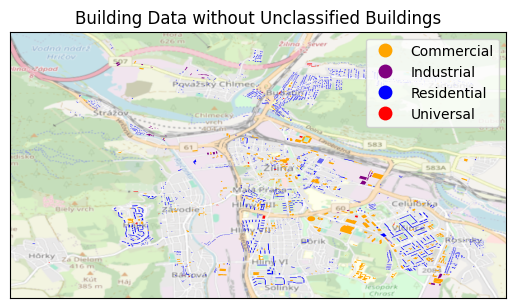

FOR NOW SUBSTITUTE Universal FOR UNDEFINED BUILDING CLASSES


C:\Users\Serrao\AppData\Local\Temp\ipykernel_2724\1959725545.py:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfOSMreclass.to_file(shpOSMreclass, encoding='utf-8')#ADDED ENCODING UTF-8 TO BE ABLE TO PROCESS SPECIAL CHARACTERS FOUND IN OSM


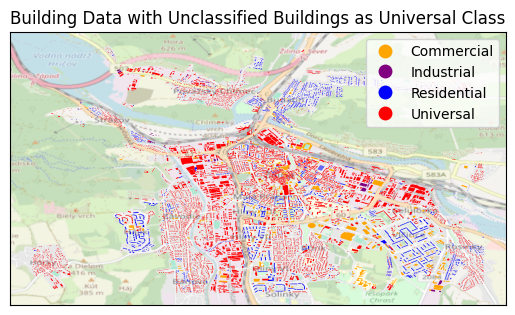

Done


In [66]:
# Shapefile name with reclassied buildings (output)
shpOSMreclass = os.path.join(dirOSM,'OSM_Building_Reclassified.shp')

# Building classification created earlier
bldgClasses = pd.read_csv(csvOSMclasses)

# Merge the spatial data with the new information
gdfOSMreclass = pd.merge(gdfOSM, bldgClasses, on='building', how='left')

if flagBuilding is True:
    # Plot without unclassified buildings
    ax = gdfOSMreclass.plot(column='bldgClass', legend=True, cmap=cmap_cls)
    ctx.add_basemap(ax, crs=gdfOSMreclass.crs, source=ctx.providers.OpenStreetMap.Mapnik,
                    attribution='', alpha=0.7)
    ax.set_xticks([]), ax.set_yticks([])
    plt.title('Building Data without Unclassified Buildings')
    plt.show()

# Substitute commercial for undefined (null) building classes
print('FOR NOW SUBSTITUTE Universal FOR UNDEFINED BUILDING CLASSES')
gdfOSMreclass['bldgClass'] = gdfOSMreclass['bldgClass'].fillna('Universal')

# Write classified structures to file
gdfOSMreclass.to_file(shpOSMreclass, encoding='utf-8')#ADDED ENCODING UTF-8 TO BE ABLE TO PROCESS SPECIAL CHARACTERS FOUND IN OSM

if flagBuilding is True:
    # Plot with unclassified buildings as commercial
    ax = gdfOSMreclass.plot(column='bldgClass', legend=True, cmap=cmap_cls)
    ctx.add_basemap(ax, crs=gdfOSMreclass.crs, source=ctx.providers.OpenStreetMap.Mapnik,
                    attribution='', alpha=0.7)
    ax.set_xticks([]), ax.set_yticks([])
    plt.title('Building Data with Unclassified Buildings as Universal Class')
    plt.show()

print('Done')

## Flood Depths
Here the flood depth rasters for each event return period are loaded.
- The raster depths are then aggregated to each based on the desired statistic (mean, maximum or minimum depth or all three).
- For each return period a map of the flood raster is generated as well as a map with the flood depths in each building.

Computing Building Water Depths:  RP= 10
  Loading water depth for selected bounds:  RP= 10
  .\data\Europe_RP10_filled_depth.tif
Computing Building Water Depths:  RP= 20
  Loading water depth for selected bounds:  RP= 20
  .\data\Europe_RP20_filled_depth.tif
Computing Building Water Depths:  RP= 50
  Loading water depth for selected bounds:  RP= 50
  .\data\Europe_RP50_filled_depth.tif
Computing Building Water Depths:  RP= 100
  Loading water depth for selected bounds:  RP= 100
  .\data\Europe_RP100_filled_depth.tif


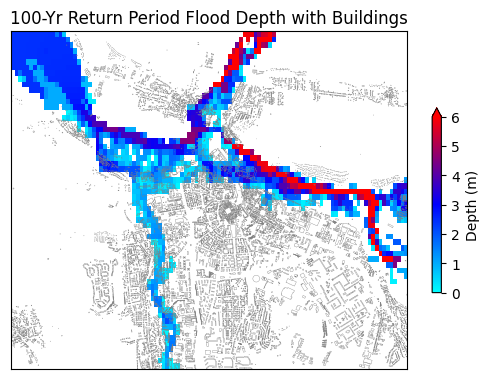

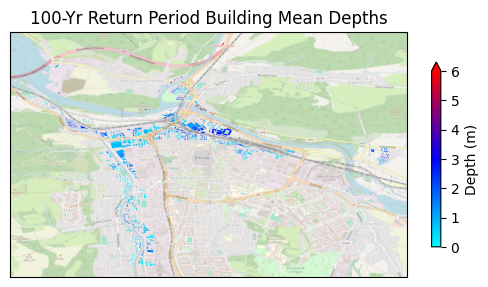

Computing Building Water Depths:  RP= 200
  Loading water depth for selected bounds:  RP= 200
  .\data\Europe_RP200_filled_depth.tif
Computing Building Water Depths:  RP= 500
  Loading water depth for selected bounds:  RP= 500
  .\data\Europe_RP500_filled_depth.tif
Done


In [67]:
for RP in ReturnPeriods:

    print("Computing Building Water Depths:  RP=", str(RP))
    print('  Loading water depth for selected bounds:  RP=', str(RP))
    rastDepths = os.path.join(dirDepths, f'Europe_RP{RP}_filled_depth.tif')
    rastDepths_zoom = rastDepths.replace('.tif', '_zoom.tif')
    print(f'  {rastDepths}')

    # Keep only the building, bldgClass and geometry columns

    gdfDamage = gdfOSMreclass[['building', 'bldgClass', 'geometry']].copy()

    # Compute building areas in m2
    gdfDamage_ESPG3035=gdfDamage.to_crs(3035)
    gdfDamage['Area_m2'] = gdfDamage_ESPG3035.geometry.area

    # Read the raster using rasterio
    with rasterio.open(rastDepths) as src:
        window = from_bounds(xMin, yMin, xMax, yMax, src.transform)
        rDepths = src.read(1, window=window)
        rDepths = np.ma.masked_where((rDepths < -999) | (rDepths > 1000), rDepths)
        missing_data_value = src.nodata

        with rasterio.open(
            rastDepths_zoom,
            'w',
            driver='GTiff',
            height=rDepths.shape[0],
            width=rDepths.shape[1],
            count=1,
            dtype=rDepths.dtype,
            crs=src.crs,
            transform=src.window_transform(window),
            nodata=missing_data_value
        ) as dst:
            dst.write(rDepths, 1)

    # Perform zonal statistics directly on the raster array
    result = rasterstats.zonal_stats(
        #gdfDamage.to_crs(src.crs),
        gdfDamage,
        rDepths,
        nodata=src.nodata,
        affine=src.window_transform(window),
        stats=['mean', 'min', 'max'],
        all_touched=True
    )

    # Update geodataframe with zonal statistics
    gdfDamage["MeanDepth"] = [entry["mean"] for entry in result]
    gdfDamage["MinDepth"] = [entry["min"] for entry in result]
    gdfDamage["MaxDepth"] = [entry["max"] for entry in result]

    if RP in ImageReturnPeriod and flagBuildingH2o is True:
        # Plot rasters
        fig, ax = plt.subplots()
        im = ax.imshow(rDepths, vmin=0, vmax=6, cmap=cmap_h2o, extent=(xMin, xMax, yMin, yMax))
        cbar = fig.colorbar(im, ax=ax, extend='max', orientation='vertical', label='Depth (m)',
                            shrink=0.5)
        gdfDamage.plot(ax=ax, edgecolor='grey', linewidth=0.25, facecolor='none')
        ax.set_xticks([]), ax.set_yticks([])
        plt.title(f'{RP}-Yr Return Period Flood Depth with Buildings')
        plt.show()
        
        # Map depths > 0 at building level
        gdf_filtered = gdfDamage[gdfDamage['MeanDepth'] > 0]
        fig, ax = plt.subplots()  # Adjust figsize as needed
        cax = gdf_filtered.plot(column='MeanDepth', vmin=0, vmax=6, cmap=cmap_h2o, ax=ax)
        cbar = fig.colorbar(cax.collections[0], extend='max', ax=ax, orientation='vertical',
                            shrink=0.5)
        cbar.set_label('Depth (m)')
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, attribution='',
                        crs=gdfDamage.crs, alpha=0.8)
        ax.set_xticks([]), ax.set_yticks([])
        plt.title(f'{RP}-Yr Return Period Building Mean Depths')
        plt.show()

    # Save the updated geodataframe to a shapefile
    shpDepths = os.path.join(dirResults, f'Depths_Building_RP{RP}.shp')
    gdfDamage.to_file(shpDepths, driver='ESRI Shapefile')

print('Done')

### Building Damage
Based on the flood water depth, the damage to the building (reconstruction costs) and its contents are determined.
- First the fractional building damage is calculated applying the JRC damage functions for each classifiction (residential, commerical, etc).
- Then the fractional damage is multiplied times the maximum damage value per square meter and the building footprint area in meters and written to a shapefile.
- The damages in millions of Euros summed over all of the classes are mapped for each return period level.

Computing Building Damage:  RP=10
Damage for Mean depth
Computing Building Damage:  RP=20
Damage for Mean depth
Computing Building Damage:  RP=50
Damage for Mean depth
Computing Building Damage:  RP=100
Damage for Mean depth


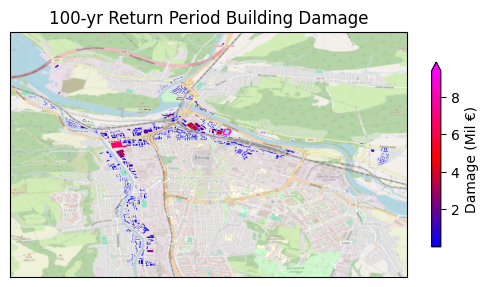

Computing Building Damage:  RP=200
Damage for Mean depth
Computing Building Damage:  RP=500
Damage for Mean depth
Done computing damage for each building


In [68]:
for RP in ReturnPeriods:

    print(f'Computing Building Damage:  RP={str(RP)}')

    # Read Building Water Depth Shapefile
    shpDepths = os.path.join(dirResults, f'Depths_Building_RP{str(RP)}.shp')
    gdfDamage = gpd.read_file(shpDepths)

    for Depth in Depths:

        if Depth == 'Mean':
            depthStat = 'mean'
        elif Depth == 'Maximum':
            depthStat = 'max'
        elif Depth == 'Minimum':
            depthStat = 'min'
        else:
            print('Depth statistic does not exist.')
            print('  Current options are Mean, Minimum, and Maximum')
            sys.exit()

        print(f'Damage for {Depth} depth')

        statName = depthStat.title() + 'Depth'

        # Compute the damage factor for each building class

        gdfDamage['TotDamage'] = 0  # Initialize TotalDamage column

        for dmgClass in DamageClasses:

            bldgDamage='f'+dmgClass[:3].upper()+depthStat
            dmgName = 'Dmg'+bldgDamage[1:]
            # Damage factors and maximum damage value including contents
            if dmgClass == 'Residential':
                gdfDamage[bldgDamage] = DamageFunction(gdfDamage[statName], coefs_RES)
                MaxDmg = MaxDmgRES.sum()
            elif dmgClass == 'Commercial':
                gdfDamage[bldgDamage] = DamageFunction(gdfDamage[statName], coefs_COM)
                MaxDmg = MaxDmgCOM.sum()
            elif dmgClass == 'Industrial':
                gdfDamage[bldgDamage] = DamageFunction(gdfDamage[statName], coefs_IND)
                MaxDmg = MaxDmgIND.sum()
            elif dmgClass == 'Transportation':
                gdfDamage[bldgDamage] = DamageFunction(gdfDamage[statName], coefs_TRS)
                MaxDmg = MaxDmgTRS.sum()
            elif dmgClass == 'Agriculture':
                gdfDamage[bldgDamage] = DamageFunction(gdfDamage[statName], coefs_AGR)
                MaxDmg = MaxDmgAGR.sum()
            elif dmgClass == 'Universal':
                gdfDamage[bldgDamage] = DamageFunction(gdfDamage[statName], coefs_UNI)
                MaxDmg = MaxDmgUNI.sum()
            else:
                gdfDamage[bldgDamage] = DamageFunction(gdfDamage[statName], coefs_UNI)
                MaxDmg = MaxDmgUNI.sum()

            # Damage computation
            gdfDamage.loc[gdfDamage['bldgClass'] != dmgClass, bldgDamage] = 0
            gdfDamage[dmgName] = gdfDamage[bldgDamage] * gdfDamage['Area_m2'] * MaxDmg

            # Add TotalDamage in millions of €
            gdfDamage['TotDamage'] += gdfDamage[dmgName] / 10**6

        gdfDamage.to_file(shpDepths, driver='ESRI Shapefile')

        # Plotting the GeoDataFrame with filtered values
        if RP in ImageReturnPeriod and flagBuildingDmg is True:
            fig, ax = plt.subplots()  # Adjust figsize as needed
            cax = gdfDamage.plot(column='TotDamage', cmap=cmap_dmg, ax=ax,zorder=2)
            cbar = fig.colorbar(cax.collections[0], extend='max', ax=ax, orientation='vertical',
                                shrink=0.5)
            cbar.set_label('Damage (Mil €)')
            ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, attribution='',
                crs=gdfDamage.crs, alpha=0.9)
            ax.set_xticks([]), ax.set_yticks([])
            plt.title(f'{str(RP)}-yr Return Period Building Damage')
            plt.show()

print('Done computing damage for each building')

### Total Damage
The total damage for the region of interest is summed, written to a CSV file, and mapped.

In [69]:
nDmg = np.append(DamageClasses, 'Total')

dfDMGs = pd.DataFrame(columns=[])
dfDMGs.index = nDmg
dfDMGs.index.name = 'Building Class'

for Depth in Depths:

    if Depth not in ['Mean', 'Maximum', 'Minimum']:
        print('Depth statistic does not exist.')
        print('  Current options are Mean, Minimum, and Maximum')
        sys.exit()

    print(f'Damage for {Depth} depth')

    for RP in ReturnPeriods:

        shpOSM = os.path.join(dirResults, f'Depths_Building_RP{RP}.shp')
        gdfOSM = gpd.read_file(shpOSM)

        vDmg = pd.DataFrame(columns=[])
        for dmgClass in DamageClasses:
            dmgName = f'DmgTRS{Depth.lower()}' if dmgClass == 'Transportation' else \
            f'Dmg{dmgClass[:3].upper()}{Depth.lower()}'
            vDmg = np.append(vDmg, gdfOSM[dmgName].sum())

        totDmg = sum(vDmg)
        vDmg = np.append(vDmg, totDmg)
        totDmg_byclass = pd.DataFrame(vDmg)
        # Assign names to the dataframe headers
        totDmg_byclass.columns = [f'{RP}-yr']
        totDmg_byclass.index = [nDmg]

        # Compute the total damage across the entire area of interest
        print(f'  RP={RP}: Total damage (€) = {round(totDmg, 3)}')

        dfDMGs[f'{RP}-yr'] = np.array(totDmg_byclass)

    damage_csv_filename = os.path.join(dirResults, f'DamageTotal_{Depth}.csv')
    dfDMGs.to_csv(damage_csv_filename)

print('Done')




Damage for Mean depth
  RP=10: Total damage (€) = 120430785.845
  RP=20: Total damage (€) = 134798969.81
  RP=50: Total damage (€) = 149943949.168
  RP=100: Total damage (€) = 162888949.081
  RP=200: Total damage (€) = 176047984.366
  RP=500: Total damage (€) = 192615615.242
Done


### Expected Annual Damage
Integrating the damage vs exceedance probability (inverse return period) curve is integrated to provide an estimate of the expected annual damage (EAD) in millions of Euros.  The is the damage that the region would expect on average in any given year.

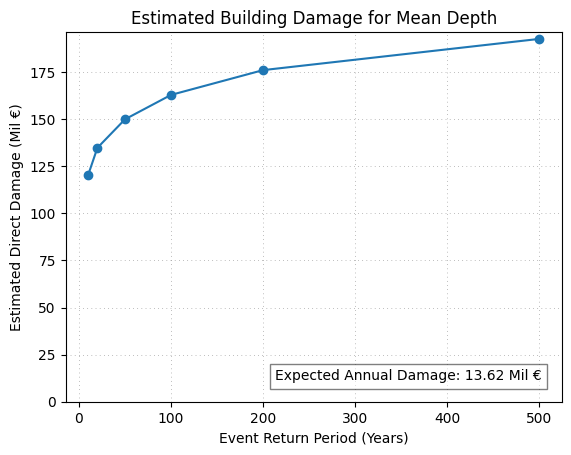

Expected Annual Damage: 13.62 Mil €
Done


In [70]:
for Depth in Depths:

    if Depth == 'Mean':
        depthStat = 'mean'
    elif Depth == 'Maximum':
        depthStat = 'max'
    elif Depth == 'Minimum':
        depthStat = 'min'
    else:
        print('Depth statistic does not exist.')
        print('  Current options are Mean, Minimum, and Maximum')
        sys.exit()

    # Load damage data for the current depth statistic
    damage_csv_filename = os.path.join(dirResults, f'DamageTotal_{Depth}.csv') #changed to Depth to match filename
    dfDMGs = pd.read_csv(damage_csv_filename, index_col=0)

    # Compute the total Estimated Annual Damage (EAD) over all return periods
    probRPs = 1 / np.array(ReturnPeriods)
    iTot = dfDMGs.index.get_loc('Total')
    EAD = 0
    for iRP in range(len(ReturnPeriods)-1):
        diffRP = probRPs[iRP] - probRPs[iRP+1]
        avgDMG = (dfDMGs.iloc[iTot, iRP+1] + dfDMGs.iloc[iTot, iRP]) / 2
        EAD = EAD + avgDMG * diffRP
        graphText = f'Expected Annual Damage: {round(EAD/10**6, 2)} Mil €'

    # Plot estimated direct damage vs exceedance probability
    if flagBuildingDmgGraph is True:
        totDmg = dfDMGs.loc['Total'] / 10**6
        plt.plot(np.array(ReturnPeriods), totDmg, marker='o', linestyle='-')
        plt.ylim(0)
        plt.grid(which='both', linestyle=':', linewidth=0.5, color='gray',dashes=(1,5))
        plt.xlabel('Event Return Period (Years)')
        plt.ylabel('Estimated Direct Damage (Mil €)')
        plt.title(f'Estimated Building Damage for {Depth} Depth')
        plt.text(0.96, 0.05, graphText, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
        plt.show()

    print(graphText)
    


print('Done')

### Population Exposed
Based on the flood water depth, the population exposed is determined.
- The population and flood rasters are compared.
- The exposed population is written to a CSV file.
- A map of the exposed popoulation is produced.
- Expected annual exposed population graph.

  Loading population for selected bounds:
  .\data\GHS_POP_E2025_GLOBE_R2023A_4326_3ss_V1_0_R4_C20_zoom.tif


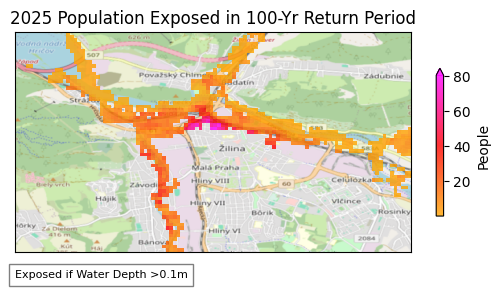

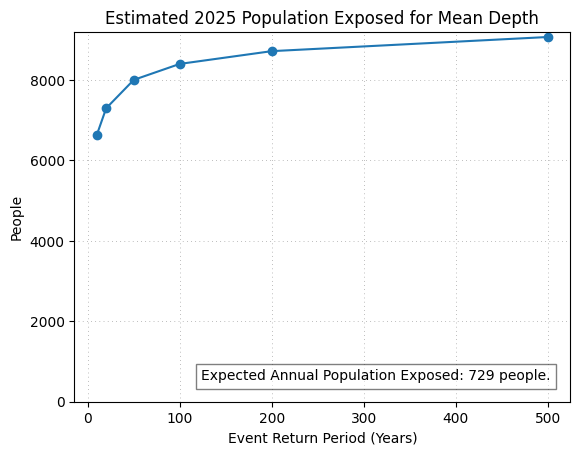

Expected Annual Population Exposed: 729 people.
Done


In [71]:
print('  Loading population for selected bounds:')
rastPopulation_zoom = rastPopulation.replace('.tif', '_zoom.tif')
print(f'  {rastPopulation_zoom}')

# Load the population data within the specified bounds
with rasterio.open(rastPopulation) as src:
    window = from_bounds(xMinPop, yMinPop, xMaxPop, yMaxPop, src.transform)
    rPopulation = src.read(1, window=window)
    rPopulation = np.ma.masked_where(rPopulation < 0.0, rPopulation)
    missing_data_value = src.nodata

    # Save the zoomed population raster
    with rasterio.open(
        rastPopulation_zoom,
        'w',
        driver='GTiff',
        height=rPopulation.shape[0],
        width=rPopulation.shape[1],
        count=1,
        dtype=rPopulation.dtype,
        crs=src.crs,
        transform=src.window_transform(window),
        nodata=missing_data_value
    ) as dst:
        dst.write(rPopulation, 1)

#Initialise population exposed array
exposedPop = []

# Process each return period
for RP in ReturnPeriods:
    rastDepths_zoom = os.path.join(dirDepths, f'Europe_RP{RP}_filled_depth_zoom.tif')
    with rasterio.open(rastDepths_zoom) as flood_src:
        rastDepths_data = flood_src.read(1)

        # Reproject the population raster to match the projection of the depths raster
        with rasterio.open(rastPopulation_zoom) as pop_src:
            pop_data = pop_src.read(1)
            pop_transform, pop_width, pop_height = calculate_default_transform(
                pop_src.crs, flood_src.crs, pop_src.width, pop_src.height, *pop_src.bounds
            )
            pop_profile = pop_src.profile.copy()
            pop_profile.update({
                'crs': flood_src.crs,
                'transform': pop_transform,
                'width': pop_width,
                'height': pop_height
            })

            # Create an empty array to store the reprojected population data
            reprojected_pop_data = np.zeros((flood_src.height, flood_src.width), dtype=pop_data.dtype)
            reproject(
                pop_data,
                reprojected_pop_data,
                src_transform=pop_src.transform,
                src_crs=pop_src.crs,
                dst_transform=pop_transform,
                dst_crs=flood_src.crs,
                resampling=Resampling.nearest
            )

            # Find the spatial intersection between the depths raster and the reprojected population raster
            exposed_population = np.where(rastDepths_data > minDepthExposed, 1, 0) * reprojected_pop_data

            # Sum the exposed population
            total_exposed = np.sum(exposed_population)
            exposedPop.append(total_exposed)

            # Save the result raster for the exposed population
            result_raster = os.path.join(dirResultsPop, os.path.basename(rastDepths_zoom).replace('.tif', '_exposed_population.tif'))
            with rasterio.open(
                result_raster,
                'w',
                driver='GTiff',
                height=exposed_population.shape[0],
                width=exposed_population.shape[1],
                count=1,
                dtype=exposed_population.dtype,
                crs=flood_src.crs,
                transform=flood_src.transform,
            ) as dst:
                dst.write(exposed_population, 1)
    

    if RP in ImageReturnPeriod and flagPopulationExp is True:
    # Plot rasters
        fig, ax = plt.subplots()
        im = ax.imshow(np.ma.masked_where((exposed_population <= 0), exposed_population), cmap=cmap_pop, extent=(xMin, xMax, yMin, yMax),
                       zorder=2,alpha=0.8)
        cbar = fig.colorbar(im, ax=ax, extend='max', orientation='vertical', label='People',
                            shrink=0.4)
        
        ctx.add_basemap(ax, crs=gdfOSM.crs, source=ctx.providers.OpenStreetMap.Mapnik,
                attribution='', alpha=1)

        ax.set_xticks([]), ax.set_yticks([])
        plt.title(f'{PopYear} Population Exposed in {RP}-Yr Return Period')
        graphText = f'Exposed if Water Depth >{minDepthExposed}m'
        plt.text(0.00, -0.08, graphText, transform=plt.gca().transAxes, fontsize=8,
             verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

        plt.show()              


# Compute the total Estimated Annual Exposed Population (EAEP) over all return periods
EAEP = 0
for iRP in range(len(ReturnPeriods)-1):
    diffRP = probRPs[iRP] - probRPs[iRP+1]
    avgPOP = (exposedPop[iRP+1] + exposedPop[iRP]) / 2
    EAEP = EAEP + avgPOP * diffRP

if flagPopulationExpGraph is True:
    plt.plot(np.array(ReturnPeriods), exposedPop, marker='o', linestyle='-')
    plt.ylim(0)
    plt.grid(which='both', linestyle=':', linewidth=0.5, color='gray',dashes=(1,5))
    plt.xlabel('Event Return Period (Years)')
    plt.ylabel('People')
    plt.title(f'Estimated {PopYear} Population Exposed for {Depth} Depth')
    graphText = f'Expected Annual Population Exposed: {round(EAEP)} people.'
    plt.text(0.96, 0.05, graphText, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
    plt.show()

print(graphText)

#CSV FILE
dfPOP = pd.DataFrame(columns=[])
dfPOP.index = ReturnPeriods
dfPOP.index.name = 'Event Return Period (years)'
dfPOP['People Exposed'] = exposedPop
population_csv_filename = os.path.join(dirResultsPop, f'ExposedPopulationTotal_{Depth}.csv')
dfPOP.to_csv(population_csv_filename)

print('Done')


### Population Displaced
Based on the flood water depth, the population displaced is a subset of the population exposed.
- The population and flood rasters are compared.
- The displaced population is written to a CSV file.
- A map of the displaced popoulation is produced.
- Expected annual displaced population graph.

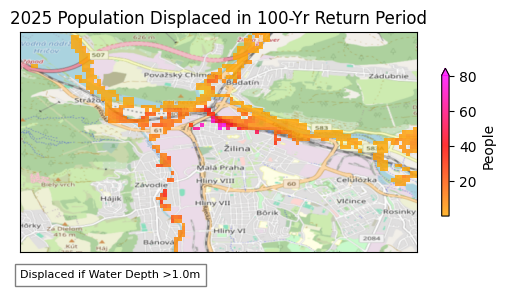

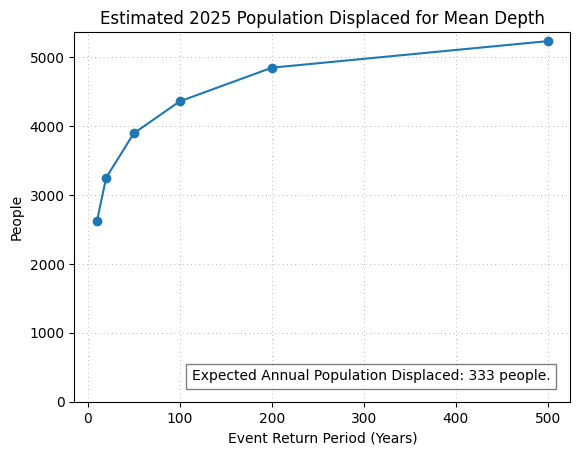

Expected Annual Population Displaced: 333 people.
Done


In [72]:
# Initialise displaced population array
displacedPop = []
# Process each return period
for RP in ReturnPeriods:
    rastDepths_zoom = os.path.join(dirDepths, f'Europe_RP{RP}_filled_depth_zoom.tif')
    with rasterio.open(rastDepths_zoom) as flood_src:
        rastDepths_data = flood_src.read(1)

        # Reproject the population raster to match the projection of the depths raster
        with rasterio.open(rastPopulation_zoom) as pop_src:
            pop_data = pop_src.read(1)
            pop_transform, pop_width, pop_height = calculate_default_transform(
                pop_src.crs, flood_src.crs, pop_src.width, pop_src.height, *pop_src.bounds
            )
            pop_profile = pop_src.profile.copy()
            pop_profile.update({
                'crs': flood_src.crs,
                'transform': pop_transform,
                'width': pop_width,
                'height': pop_height
            })

            # Create an empty array to store the reprojected population data
            reprojected_pop_data = np.zeros((flood_src.height, flood_src.width), dtype=pop_data.dtype)
            reproject(
                pop_data,
                reprojected_pop_data,
                src_transform=pop_src.transform,
                src_crs=pop_src.crs,
                dst_transform=pop_transform,
                dst_crs=flood_src.crs,
                resampling=Resampling.nearest
            )

            # Find the spatial intersection between the depths raster and the reprojected population raster
            displaced_population = np.where(rastDepths_data > minDepthDisplaced, 1, 0) * reprojected_pop_data

            # Sum the exposed population
            total_displaced = np.sum(displaced_population)
            displacedPop.append(total_displaced)

            # Save the result raster for the exposed population
            result_raster = os.path.join(dirResultsPop, os.path.basename(rastDepths_zoom).replace('.tif', '_displaced_population.tif'))
            with rasterio.open(
                result_raster,
                'w',
                driver='GTiff',
                height=displaced_population.shape[0],
                width=displaced_population.shape[1],
                count=1,
                dtype=displaced_population.dtype,
                crs=flood_src.crs,
                transform=flood_src.transform,
            ) as dst:
                dst.write(displaced_population, 1)
    

    if RP in ImageReturnPeriod and flagPopulationDis is True:
    # Plot rasters
        fig, ax = plt.subplots()
        im = ax.imshow(np.ma.masked_where((displaced_population <= 0), displaced_population), cmap=cmap_pop, extent=(xMin, xMax, yMin, yMax),
                       zorder=2,alpha=0.8)
        cbar = fig.colorbar(im, ax=ax, extend='max', orientation='vertical', label='People',
                            shrink=0.4)
        
        ctx.add_basemap(ax, crs=gdfOSM.crs, source=ctx.providers.OpenStreetMap.Mapnik,
                attribution='', alpha=1)

        ax.set_xticks([]), ax.set_yticks([])
        plt.title(f'{PopYear} Population Displaced in {RP}-Yr Return Period')
        graphText = f'Displaced if Water Depth >{minDepthDisplaced}m'
        plt.text(0.00, -0.08, graphText, transform=plt.gca().transAxes, fontsize=8,
             verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

        plt.show()              


# Compute the total Estimated Annual Displaced Population (EADP) over all return periods
EADP = 0
for iRP in range(len(ReturnPeriods)-1):
    diffRP = probRPs[iRP] - probRPs[iRP+1]
    avgPOP = (displacedPop[iRP+1] + displacedPop[iRP]) / 2
    EADP = EADP + avgPOP * diffRP

if flagPopulationDisGraph is True:
    plt.plot(np.array(ReturnPeriods), displacedPop, marker='o', linestyle='-')
    plt.ylim(0)
    plt.grid(which='both', linestyle=':', linewidth=0.5, color='gray',dashes=(1,5))
    plt.xlabel('Event Return Period (Years)')
    plt.ylabel('People')
    plt.title(f'Estimated {PopYear} Population Displaced for {Depth} Depth')
    graphText = f'Expected Annual Population Displaced: {round(EADP)} people.'
    plt.text(0.96, 0.05, graphText, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
    plt.show()

print(graphText)

#CSV FILE
dfPOP = pd.DataFrame(columns=[])
dfPOP.index = ReturnPeriods
dfPOP.index.name = 'Event Return Period (years)'
dfPOP['People Exposed'] = exposedPop
population_csv_filename = os.path.join(dirResultsPop, f'DisplacedPopulationTotal_{Depth}.csv')
dfPOP.to_csv(population_csv_filename)

print('Done')


### Critical Infrastructure
In order to visualise the exposure of critical infrastructure for the area of interest, the OSM dataset is used:
- Markers and colours are attributed for each type of critical infrastructure.
- Flood water depths are read.
- Critical infrastructure and floods are mapped together.

C:\Users\Serrao\AppData\Local\Temp\ipykernel_2724\1908659115.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdfOSMreclass['critInfrastructure'] = gdfOSMreclass['critInfrastructure'].fillna(False).astype(bool)
C:\Users\Serrao\AppData\Local\Temp\ipykernel_2724\1908659115.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  crit_buildings.centroid.plot(ax=ax, marker=markerItem, color=colourItem, markersize=20, label=f'{building_type.capitalize()}')
C:\Users\Serrao\AppData\Local\Temp\ipykernel_2724\1908659115.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()'

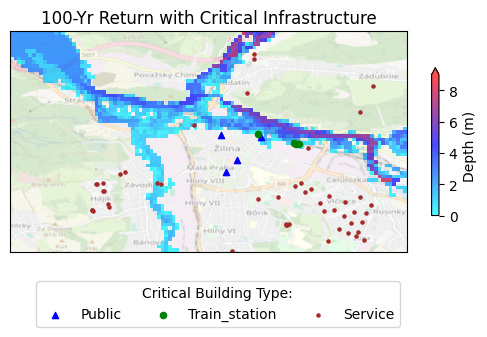

In [73]:
# Ensure the critical column is boolean
gdfOSMreclass['critInfrastructure'] = gdfOSMreclass['critInfrastructure'].fillna(False).astype(bool)

critMarkersColours = {
    'hospital': {'marker': 's', 'color': 'red'}, 
    'public': {'marker': '^', 'color': 'blue'}, 
    'train_station': {'marker': 'o', 'color': 'green'}, 
    'transformer_tower': {'marker': '*', 'color': 'purple'}, 
    'water_tower': {'marker': 'x', 'color': 'orange'}, 
    'bridge': {'marker': 'd', 'color': 'brown'}, 
    'fire_station': {'marker': '+', 'color': 'pink'}, 
    'transportation': {'marker': '>', 'color': 'cyan'}, 
    'service': {'marker': '.', 'color': 'brown'}
}  # Add more as needed

for RP in ImageReturnPeriod:
    rastDepths = os.path.join(dirDepths, f'Europe_RP{RP}_filled_depth_zoom.tif')
    # Read the TIFF image
    with rasterio.open(rastDepths) as src:
        rDepths = src.read(1)  # Reading the first band
        rDepths = np.ma.masked_where((rDepths < -999) | (rDepths > 1000), rDepths)
        # Compute the maximum value from the masked data
        max_depth  = rDepths.max()
        # Find the closest multiple of 100 above the max_population value
        maxDepthLegend = ((max_depth // 1) + 1)
        missing_data_value = src.nodata

    # Create the plot
    fig, ax = plt.subplots()

    # Plot the background image using imshow
    im = ax.imshow(rDepths, vmin=0, vmax=maxDepthLegend, cmap=cmap_h2o, extent=(xMin, xMax, yMin, yMax),
                zorder=1, alpha=0.7)
    cbar = fig.colorbar(im, ax=ax, extend='max', orientation='vertical', label='Depth (m)', shrink=0.4)

    # Collect critical buildings for all building types
    for building_type, props in critMarkersColours.items():
        markerItem = props['marker']
        colourItem = props['color']
        if building_type in gdfOSMreclass['building'].unique():
            crit_buildings = gdfOSMreclass[(gdfOSMreclass['critInfrastructure']) & (gdfOSMreclass['building'] == building_type)]
            crit_buildings.centroid.plot(ax=ax, marker=markerItem, color=colourItem, markersize=20, label=f'{building_type.capitalize()}')

    # Optionally, add basemap if needed
    ctx.add_basemap(ax=ax, crs=gdfDamage.crs, source=ctx.providers.OpenStreetMap.Mapnik, attribution='', alpha=0.5)

    #Legend
    legend = ax.legend(loc='best', ncol=3, bbox_to_anchor=(1.0, -0.1),
                       title='Critical Building Type:')
    
    ax.set_xticks([]), ax.set_yticks([])
    plt.title(f'{RP}-Yr Return with Critical Infrastructure')
    plt.show()